# Notebook: Estudo da variação da quantidade de ruído

Descrição do conteúdo:

Neste notebook, criam-se transientes com níveis crescentes de ruído, os quais são utilizados para gerar espectrogramas/espectros/projeções (Seção 1.0) que são analisadas de modo qualitativo e quantitativo (seções 2.0 a 7.0), afim de caracterizar o efeito do ruído.

Primeiramente, visualiza-se espectrogramas com ruído para entender a manifestação desse no domínio do espectrograma (Seção 2.0). Em seguida, observa-se projeções na frequência obtidas pelo espectrograma e compara-as ao espectro de GABA (Seção 3.0). Essa análise é seguida da estimação do ruído em cada um desses domínios (Seção 4.0).

Posteriormente, observa-se se o ruído impacta nas medições de largura dos picos (FWHM) (Seção 5.0) e na medição associada as listras dos picos (ZCR) (Seção 6.0).

Finalmente, define-se um método de segmentação de diferentes regiões do espectrograma e extraí-se características de cada região em função do nível de ruído (Seção 7.0).

Os resultados quantitativos dessa análise são salvos em um arquivo dedicado (Seção 8.0).

## 0.0 Definições

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import h5py
from scipy.signal.windows import hann
from matplotlib import gridspec
import json

In [2]:
import utils
import functions_for_noise_study as noisestud
import functions_for_param_study as paramstud

## 1.0 Preparação: Aquisição dos sinais simulados e geração dos espectrogramas/espectros

In [99]:
qntty = 100
test_not_save = False

In [4]:
#Import data obtained on EditedMRS_Reconstruction_Challenge github -- Ground-truths
with h5py.File('../sample_data.h5') as hf:
  print(hf.keys())
  gt_fids = hf["ground_truth_fids"][()][:qntty]
  ppm = hf["ppm"][()][:qntty]
  t = hf["t"][()][:qntty]
  print(gt_fids.shape)
  print(ppm.shape)
  print(t.shape)

<KeysViewHDF5 ['ground_truth_fids', 'ppm', 't']>
(100, 2048, 2)
(100, 2048)
(100, 2048)


In [5]:
dwelltime = t[0,1]-t[0,0]
bandwidth = 1/dwelltime
N = gt_fids.shape[1]

#note: if we use np.fft.fftshift(np.fft.ifft()) to get the spectrum, if we use np.flip(np.fft.fftshift(np.fft.fftfreq())) the frequency values
#will start from the most positive to the most negative, as in the ppm axis. Then freq[i] will have its correspondent ppm value in ppm[i]
#and the spectrum in the frequency freq[i] will be obtainted by spectrum[0,i]
#however, this is by using the inverse fourier transform to get the spectrum, and we want to use the Fourier transform
#for this we do np.fft.fftshift(np.fft.fft()) to get the spectrum, but still we flip the frequency axis as np.flip(np.fft.fftshift(np.fft.fftfreq())),
#so the freq[i] will have its correspondent ppm value in ppm[i], but the spectrum at a given frequency f will occur at 
#spectrum[0,np.abs(np.flip(freq)-f).argmin()], i.e. the frequency axis is flipped with respect to the spectrum, and the ppm axis as well
#this also happens for the spectrogram...
#gts
spectra_gt_fids = np.fft.fftshift(np.fft.fft(gt_fids,n=N,axis = 1), axes = 1)
spectra_gt_diff = spectra_gt_fids[:,:,1] - spectra_gt_fids[:,:,0]
freq = np.flip(np.fft.fftshift(np.fft.fftfreq(N, d = dwelltime)))
#to get ppm axis
idx_min = np.real(spectra_gt_diff[0,:]).argmin()
idx_max = np.real(spectra_gt_diff[0,:]).argmax()
#p = a*f + b
#not really necessary to flip to find a and b since freq and ppm agree, but we use it to enphasize the flip
#and also so np.flip(ppm)[0,idx_max] = 4.7 ppm, np.flip(ppm)[0,idx_min] = 2 ppm
#and np.flip(freq)[idx_max] = 216 Hz, and np.flip(freq)[idx_min] = -127 Hz, which agree with visual observation
a = (np.flip(ppm)[0,idx_max] - np.flip(ppm)[0,idx_min])/(np.flip(freq)[idx_max]-np.flip(freq)[idx_min])
b = np.flip(ppm)[0,idx_max] - a*np.flip(freq)[idx_max]
#ppm_aux = b + freq*a

spectrum_gt = np.empty(spectra_gt_diff.shape,dtype=spectra_gt_diff.dtype)
for j in range(spectra_gt_diff.shape[0]):
    spectrum_gt[j,:] = utils.normalize_complex_vector_abs(complex_array=spectra_gt_diff[j,:])

In [6]:
#create fids with noise
corrupted_fids = {}
std_basis = [1,2,3,4,5,6,7,8,9,10,12,15,17,19]
var_basis = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.5,1.5,1.5,1.5]
for i in range(len(std_basis)):
    corrupted_fids["noise_"+str(std_basis[i])] = utils.create_corrupted_fids(gt=gt_fids,t=t,std_base=std_basis[i],std_var=var_basis[i],ntransients=160)

In [7]:
#spectrogram (spgram) parameters
mfft_ = 600
window_ = hann(mfft_,sym=True)
hop_ = 12
norm_ = 'abs'

In [8]:
spgram_gt, freq_spect, ppm_spect, t_spect = utils.get_normalized_spectrogram(fids=gt_fids[:,:,1]-gt_fids[:,:,0],bandwidth=bandwidth,window=window_,mfft=mfft_,hop=hop_,norm=norm_,correct_time=True,a=a,b=b)

In [9]:
spgram_ns = {}
for i in range(len(std_basis)):
    spgram, freq_spect, ppm_spect, t_spect = utils.get_normalized_spectrogram(fids=np.mean(corrupted_fids["noise_"+str(std_basis[i])][:,:,1,:]-corrupted_fids["noise_"+str(std_basis[i])][:,:,0,:],axis=2),bandwidth=bandwidth,window=window_,mfft=mfft_,hop=hop_,norm=norm_,correct_time=True,a=a,b=b)
    spgram_ns['noise_'+str(std_basis[i])] = [spgram, freq_spect, ppm_spect, t_spect]

In [10]:
#spectrum generation for reference
spectrum_ns = {}
for i in range(len(std_basis)):
    aux_spectrum = np.fft.fftshift(np.fft.fft(np.mean(corrupted_fids["noise_"+str(std_basis[i])][:,:,1,:]-corrupted_fids["noise_"+str(std_basis[i])][:,:,0,:],axis=2),n=N,axis = 1), axes = 1)
    norm_spectrum = np.empty(aux_spectrum.shape,dtype=aux_spectrum.dtype)
    for j in range(aux_spectrum.shape[0]):
        norm_spectrum[j,:] = utils.normalize_complex_vector_abs(complex_array=aux_spectrum[j,:])
    spectrum_ns['noise_'+str(std_basis[i])] = norm_spectrum

Algumas colunas e linhas de interesse na análise dos espectrogramas:

In [17]:
list_of_t_spects = []
list_of_ppm_spects = []
for i in range(len(std_basis)):
    list_of_t_spects.append(spgram_ns['noise_'+str(std_basis[i])][-1])
    list_of_ppm_spects.append(spgram_ns['noise_'+str(std_basis[i])][2])
#lists with index of time/ppm points in the spectrograms
idx_time_0d05 = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects,time_point=0.05)
idx_time_0d4 = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects,time_point=0.4)
idx_time_0d6 = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects,time_point=0.6)
idx_freq_0ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=0)
idx_freq_1ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=1)
idx_freq_4ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=4)
idx_freq_8ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=8)
idx_freq_8d5ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=8.5)
idx_freq_NAA = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=2.02)
idx_freq_GABA = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=3.00)
idx_freq_Glx = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=3.75)

## 2.0 Visualização do Espectrograma:

Da visualização do espectrograma, nota-se que o ruído se manifesta criando um padrão de fundo com 'faixas de oscilação' que variam em frequência (perfil em verde: alta frequência, perfil em rosa: baixa frequência). Conforme aumenta a intensidade do ruído, aumenta a intensidade dos padrões de fundo, visíveis com o contraste utilizado a partir de ruído de nível 4. Visualmente, não se nota diferença na região de picos mais intensos.

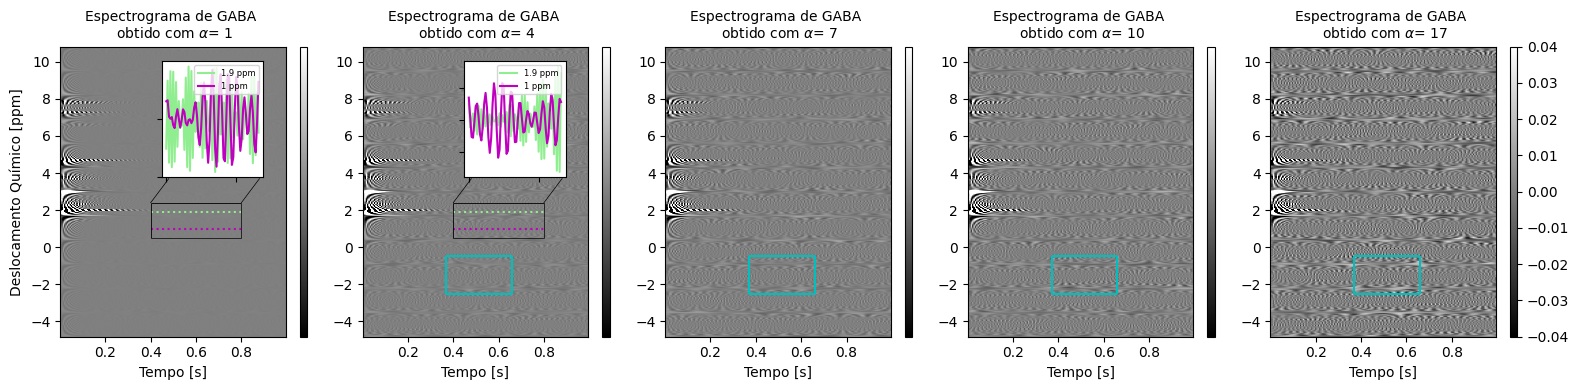

In [16]:
plot_idx = np.arange(0,len(std_basis),3)
fig,ax = plt.subplots(1,5,figsize=(16,4))
for k in range(len(plot_idx)):
    im = ax.flat[k].imshow(np.real(spgram_ns["noise_"+str(std_basis[plot_idx[k]])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
          extent = (spgram_ns["noise_"+str(std_basis[plot_idx[k]])][-1][0],spgram_ns["noise_"+str(std_basis[plot_idx[k]])][-1][-1],
                    spgram_ns["noise_"+str(std_basis[plot_idx[k]])][2][-1],spgram_ns["noise_"+str(std_basis[plot_idx[k]])][2][0]))
    ax.flat[k].set_title('Espectrograma de GABA \n obtido com ' +r'$\alpha$= '+str(std_basis[plot_idx[k]]),fontsize=10)
    ax.flat[k].set_xlabel('Tempo [s]')
    if k == 0:
        ax.flat[k].set_ylabel('Deslocamento Químico [ppm]')
    if k == 4:
        plt.colorbar(im,ax=ax[k],aspect=40)
    else:
        plt.colorbar(im,ax=ax[k],aspect=40,ticks = matplotlib.ticker.FixedLocator([]))

for k in range(2):
    axins1 = ax.flat[k].inset_axes([0.45, 0.55, 0.45, 0.4], xticklabels=[], yticklabels=[])
    axins1.plot(np.real(spgram_ns["noise_"+str(std_basis[plot_idx[k]])][0][0,223,66:133]),color='lightgreen',label='1.9 ppm')
    axins1.plot(np.real(spgram_ns["noise_"+str(std_basis[plot_idx[k]])][0][0,258,66:133]),color='m', label='1 ppm')
    axins1.legend(loc='upper right',fontsize=6)
    ax.flat[k].hlines(1,0.4,0.8,color='m',linestyle='dotted')
    ax.flat[k].hlines(1.9,0.4,0.8,color='lightgreen',linestyle='dotted')
    ax.flat[k].hlines(0.5,0.4,0.8,color='black',linewidth=0.5)
    ax.flat[k].hlines(2.4,0.4,0.8,color='black',linewidth=0.6)
    ax.flat[k].vlines(0.4,0.5,2.4,color='black',linewidth=0.6)
    ax.flat[k].vlines(0.8,0.5,2.4,color='black',linewidth=0.5)
    ax.flat[k].plot([0.4,0.48],[2.4,3.7],color='black',linewidth=0.5)
    ax.flat[k].plot([0.8,0.88],[2.4,3.7],color='black',linewidth=0.5)

for i in range(1,5):
    ax.flat[i].hlines(-2.5,0.37,0.66,color='c')
    ax.flat[i].hlines(-0.5,0.37,0.66,color='c')
    ax.flat[i].vlines(0.37,-2.5,-0.5,color='c')
    ax.flat[i].vlines(0.66,-2.5,-0.5,color='c')

plt.tight_layout()
if test_not_save == False:
    plt.savefig('./relatorio_imagens/imagens_noise/spgram_varying_noise_level.png')

Visualização de espectrogramas concatenados:

In [12]:
aux_concat = (np.arange(0,len(std_basis),3)).tolist()
selected_keys = []
list_time_idx = []
for i in range(len(aux_concat)):
    selected_keys.append('noise_'+str(std_basis[aux_concat[i]]))
    list_time_idx.append(idx_time_0d4[aux_concat[i]])
spgram_ns_concat = utils.concatenate_generic(selected_keys=selected_keys,spgram_dict=spgram_ns,list_time_idx=list_time_idx,fid_idx_plot=0)

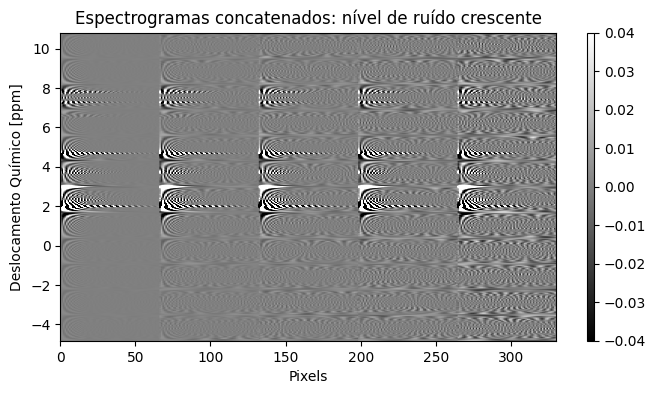

In [77]:
fig,ax=plt.subplots(1,1,figsize=(8,4))
im = ax.imshow(np.real(spgram_ns_concat), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
              extent=(0,spgram_ns_concat.shape[-1],spgram_ns['noise_'+str(std_basis[0])][2][-1],
                      spgram_ns['noise_'+str(std_basis[0])][2][0]))
plt.colorbar(im,ax=ax,aspect=45)
plt.title('Espectrogramas concatenados: nível de ruído crescente')
plt.xlabel('Pixels')
plt.ylabel('Deslocamento Químico [ppm]')
if test_not_save == False:
    plt.savefig('./relatorio_imagens/imagens_noise/spgram_varying_noise_level_concat.png')

## 3.0 Visualização de projeções na frequência e espectro:

A projeção do espectrograma no eixo da frequência dá origem a um sinal unidimensional similar ao espectro de GABA. Essa similaridade é interessante pois permite utilizar métodos de estimação de ruído propostos para o espectro no domínio da projeção, sendo essa uma possibilidade de medir indiretamente o ruído no espectrograma. 

Duas projeções são consideradas: a projeção direta da parte real da STFT (proj(Espectrograma)) e a projeção da magnitude da parte real da STFT (proj(|Espectrograma|)). 

Proj(|Espectrograma|) se assemelha mais com o espectro, no entanto, o nível médio da projeção aumenta com o nível de ruído, o que não ocorre com o espectro.

Proj(Espectrograma) apresenta picos de formatos diferentes do que se observa no espectro, mas o pico de GABA (3 ppm) é o mais alto do sinal, enquanto em Proj(|Espectrograma|) e no espectro, o pico de NAA é o mais amplo (2 ppm, é negativo no espectro de GABA).

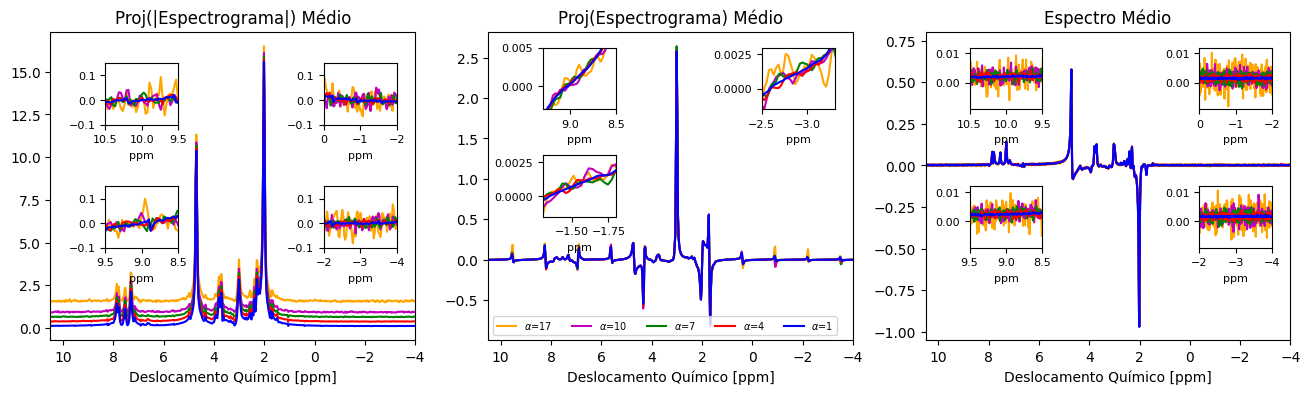

In [18]:
fig, ax = plt.subplots(1,3,figsize=(16,4))
plot_idx = np.arange(0,len(std_basis),3)
axins1 = ax.flat[0].inset_axes([0.15, 0.7, 0.2, 0.2])
axins2 = ax.flat[0].inset_axes([0.15, 0.3, 0.2, 0.2])
axins3 = ax.flat[0].inset_axes([0.75, 0.7, 0.2, 0.2])
axins4 = ax.flat[0].inset_axes([0.75, 0.3, 0.2, 0.2])
axins5 = ax.flat[1].inset_axes([0.15, 0.75, 0.2, 0.2])
axins6 = ax.flat[1].inset_axes([0.15, 0.4, 0.2, 0.2])
axins7 = ax.flat[1].inset_axes([0.75, 0.75, 0.2, 0.2])
axins8 = ax.flat[2].inset_axes([0.12, 0.75, 0.2, 0.2])
axins9 = ax.flat[2].inset_axes([0.12, 0.3, 0.2, 0.2])
axins10 = ax.flat[2].inset_axes([0.75, 0.75, 0.2, 0.2])
axins11 = ax.flat[2].inset_axes([0.75, 0.3, 0.2, 0.2])

axins1.set_xlim(10.5,9.5)
axins1.set_ylim(-0.1,0.15)
axins1.tick_params(axis='both', which='major', labelsize=8)
axins2.set_xlim(9.5,8.5)
axins2.set_ylim(-0.1,0.15)
axins2.tick_params(axis='both', which='major', labelsize=8)
axins3.set_xlim(0,-2)
axins3.set_ylim(-0.1,0.15)
axins3.tick_params(axis='both', which='major', labelsize=8)
axins4.set_xlim(-2,-4)
axins4.set_ylim(-0.1,0.15)
axins4.tick_params(axis='both', which='major', labelsize=8)

axins5.set_xlim(9.3,8.5)
axins5.set_ylim(-0.003,0.005)
axins5.tick_params(axis='both', which='major', labelsize=8)
axins6.set_xlim(-1.3,-1.8)
axins6.set_ylim(-0.0015,0.003)
axins6.tick_params(axis='both', which='major', labelsize=8)
axins7.set_xlim(-2.5,-3.3)
axins7.set_ylim(-0.0015,0.003)
axins7.tick_params(axis='both', which='major', labelsize=8)

axins8.set_xlim(10.5,9.5)
axins8.set_ylim(-0.009,0.012)
axins8.tick_params(axis='both', which='major', labelsize=8)
axins9.set_xlim(9.5,8.5)
axins9.set_ylim(-0.009,0.012)
axins9.tick_params(axis='both', which='major', labelsize=8)
axins10.set_xlim(0,-2)
axins10.set_ylim(-0.009,0.012)
axins10.tick_params(axis='both', which='major', labelsize=8)
axins11.set_xlim(-2,-4)
axins11.set_ylim(-0.009,0.012)
axins11.tick_params(axis='both', which='major', labelsize=8)

axins1.set_xlabel('ppm',fontsize=8)
axins2.set_xlabel('ppm',fontsize=8)
axins3.set_xlabel('ppm',fontsize=8)
axins4.set_xlabel('ppm',fontsize=8)
axins5.set_xlabel('ppm',fontsize=8)
axins6.set_xlabel('ppm',fontsize=8)
axins7.set_xlabel('ppm',fontsize=8)
axins8.set_xlabel('ppm',fontsize=8)
axins9.set_xlabel('ppm',fontsize=8)
axins10.set_xlabel('ppm',fontsize=8)
axins11.set_xlabel('ppm',fontsize=8)

colors = ['b','r','g','m','orange','c']
for k in reversed(range(len(plot_idx))):
    
    aux = np.sum(np.abs(np.real(spgram_ns["noise_"+str(std_basis[plot_idx[k]])][0])),axis=2)
    ax[0].plot(np.flip(spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2]),np.mean(aux,axis=0), label = r'$\alpha$='+str(std_basis[plot_idx[k]]),color=colors[k])
    ax[0].set_xlim(10.5,-4)
    
    index_10d5 = utils.give_idx_ppm_point(ppm_array=spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2],ppm_point=10.5)
    index_9d5 = utils.give_idx_ppm_point(ppm_array=spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2],ppm_point=9.5)
    index_8d5 = utils.give_idx_ppm_point(ppm_array=spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2],ppm_point=8.5)
    index_0 = utils.give_idx_ppm_point(ppm_array=spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2],ppm_point=0)
    index_minus2 = utils.give_idx_ppm_point(ppm_array=spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2],ppm_point=-2)
    index_minus4 = utils.give_idx_ppm_point(ppm_array=spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2],ppm_point=-4)
    
    axins1.plot(np.flip(spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2]),np.mean(aux,axis=0)-np.mean(np.mean(aux,axis=0)[index_9d5:index_10d5]),color=colors[k])
    axins2.plot(np.flip(spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2]),np.mean(aux,axis=0)-np.mean(np.mean(aux,axis=0)[index_8d5:index_9d5]),color=colors[k])
    axins3.plot(np.flip(spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2]),np.mean(aux,axis=0)-np.mean(np.mean(aux,axis=0)[index_minus2:index_0]),color=colors[k])
    axins4.plot(np.flip(spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2]),np.mean(aux,axis=0)-np.mean(np.mean(aux,axis=0)[index_minus4:index_minus2]),color=colors[k])
    
    aux = np.sum(np.real(spgram_ns["noise_"+str(std_basis[plot_idx[k]])][0]),axis=2)
    ax[1].plot(np.flip(spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2]),np.mean(aux,axis=0), label = r'$\alpha$='+str(std_basis[plot_idx[k]]),color=colors[k])
    ax[1].set_xlim(10.5,-4)
        
    axins5.plot(np.flip(spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2]),np.mean(aux,axis=0),color=colors[k])
    axins6.plot(np.flip(spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2]),np.mean(aux,axis=0),color=colors[k])
    axins7.plot(np.flip(spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2]),np.mean(aux,axis=0),color=colors[k])
    
    aux = np.real(spectrum_ns["noise_"+str(std_basis[plot_idx[k]])])
    ax[2].plot(np.flip(ppm[0,:]),np.mean(aux,axis=0), label = r'$\alpha$='+str(std_basis[plot_idx[k]]),color=colors[k])
    ax[2].set_xlim(10.5,-4)
    ax[2].set_ylim(-1.05,0.8)
    
    
    axins8.plot(np.flip(ppm[0,:]),np.mean(aux,axis=0),color=colors[k])
    axins9.plot(np.flip(ppm[0,:]),np.mean(aux,axis=0),color=colors[k])
    axins10.plot(np.flip(ppm[0,:]),np.mean(aux,axis=0),color=colors[k])
    axins11.plot(np.flip(ppm[0,:]),np.mean(aux,axis=0),color=colors[k])

ax[0].set_xlabel('Deslocamento Químico [ppm]')
ax[0].set_title('Proj(|Espectrograma|) Médio')
ax[1].set_xlabel('Deslocamento Químico [ppm]')
ax[1].set_title('Proj(Espectrograma) Médio')
ax[2].set_xlabel('Deslocamento Químico [ppm]')
ax[2].set_title('Espectro Médio')
ax[1].legend(loc='lower left',ncols=5,fontsize=7)
    
if test_not_save == False:
    plt.savefig('./relatorio_imagens/imagens_noise/projections_noise.png')

## 4.0 Estimação do nível de ruído do espectrograma/espectro:

Para entender como estimar o nível de ruído no domínio do espectrograma e como isso se compara com o ruído no espectro, estima-se o ruído nas projeções na frequência, no espectrograma diretamente e no espectro.

Para a medição do nível de ruído define-se as seguintes regiões:
-  Para proj(|Espectrograma|) e para o espectro de GABA:
    - Regiões: 9.5 - 10.5 ppm, 8.5 - 9.5 ppm, -2 a 0 ppm e -4 a -2 ppm.
- Para proj(Espectrograma):
    - Regiões: 8.5 - 9.3 ppm, -1.8 a -1.3 ppm e -3.3 a -2.5 ppm
    
A medição do nível de ruído nas projeções e no espectro é feita através de um fitting de um polinômio de segundo grau, o qual é subtraído dos dados para então estimar-se o nível de ruído através do desvio padrão desse sinal.

Além disso, mede-se o nível de ruído diretamente no espectrograma, considerando as colunas entre 0,6s e 1s para as regiões:
-  9.5 - 10.5 ppm, 8.5 - 9.5 ppm, -2 a 0 ppm e -4 a -2 ppm
Para estimação direta, simplesmente toma-se o desvio-padrão de uma região com a intensidade dos pixels subtraídas de seu valor médio.

In [19]:
#estimating noise level in the projections domain
list_ppm_regions_abs = [[9.5,10.5],[8.5,9.5],[-2,0],[-4,-2]]
list_ppm_regions_real = [[8.5,9.3],[-1.8,-1.3],[-3.3,-2.5]]
list_projections_abs = []
list_projections_real = []
list_ppm_array = []
for i in range(len(std_basis)):
    list_projections_abs.append(np.sum(np.abs(np.real(spgram_ns["noise_"+str(std_basis[i])][0])),axis=2))
    list_projections_real.append(np.sum(np.real(spgram_ns["noise_"+str(std_basis[i])][0]),axis=2))
    list_ppm_array.append(spgram_ns["noise_"+str(std_basis[i])][2])
std_estimate_abs = noisestud.spect_noise_estimation(list_spects=list_projections_abs,list_ppm_arrays=list_ppm_array,list_ppm_regions=list_ppm_regions_abs,part='real',degree=2)
std_estimate_real = noisestud.spect_noise_estimation(list_spects=list_projections_real,list_ppm_arrays=list_ppm_array,list_ppm_regions=list_ppm_regions_real,part='real',degree=2)

In [22]:
#estimating noise level directly in the spectrogram
list_ppm_regions_spgram = [[9.5,10.5],[8.5,9.5],[-2,0],[-4,-2]]
std_estimated_in_spgram = noisestud.spgram_noise_estimation(spgram_dict=spgram_ns,list_ppm_regions=list_ppm_regions_spgram,part='real')

In [23]:
#estimating noise level in the spectrum
list_ppm_regions_spectrum = [[9.5,10.5],[8.5,9.5],[-2,0],[-4,-2]]
list_spectrum = []
list_ppm_array_spectrum = []
for i in range(len(std_basis)):
    list_spectrum.append(np.real(spectrum_ns["noise_"+str(std_basis[i])]))
    list_ppm_array_spectrum.append(ppm[0,:])
std_estimate_spectrum = noisestud.spect_noise_estimation(list_spects=list_spectrum,list_ppm_arrays=list_ppm_array_spectrum,list_ppm_regions=list_ppm_regions_spectrum,part='real',degree=2)

Visualização dos fits no espectrograma:

Da observação da qualidade dos fits, nota-se que o fitting polinomial parece descrever bem a tendência das regiões da projeção real do espectrograma e das regiões do espectro, porém, o fitting nas regiões da projeção do valor absoluto do espectrograma parece superestimar os valores da região.

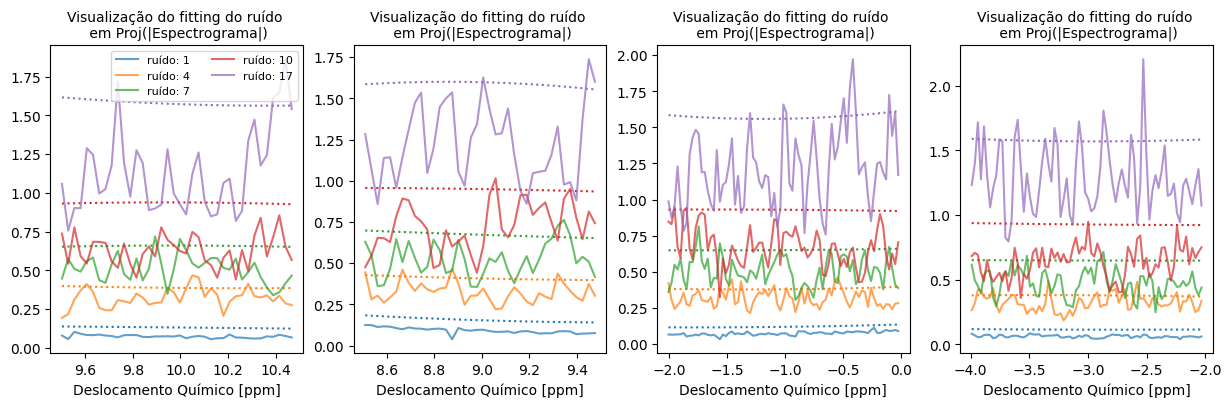

In [35]:
#change the boolean to check the fits in each projection or in the spectrum
plot_projection = True
plot_abs = True
transient_idx = 0

colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']
plot_idx = np.arange(0,len(std_basis),3)

if plot_projection == True and plot_abs == False:
    ncols = len(list_ppm_regions_real)
    list_regions = list_ppm_regions_real
    std_estimate = std_estimate_real
    title = 'Visualização do fitting do ruído \n em Proj(Espectrograma)'
elif plot_projection == True and plot_abs == True:
    ncols = len(list_ppm_regions_abs)
    list_regions = list_ppm_regions_abs
    std_estimate = std_estimate_abs
    title = 'Visualização do fitting do ruído \n em Proj(|Espectrograma|)'
else:
    ncols = len(list_ppm_regions_spectrum)
    list_regions = list_ppm_regions_spectrum
    std_estimate = std_estimate_spectrum
    title = 'Visualização do fitting do ruído \n no espectro'

fig,ax = plt.subplots(1,ncols,figsize=(15,4))
for k in range(len(plot_idx)):
    for j in range(ncols):
        if plot_projection == True:
            idx_str = utils.give_idx_ppm_point(ppm_array=spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2],ppm_point=list_regions[j][0])
            idx_end = utils.give_idx_ppm_point(ppm_array=spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2],ppm_point=list_regions[j][1])
        else:
            idx_str = utils.give_idx_ppm_point(ppm_array=ppm[0,:],ppm_point=list_regions[j][0])
            idx_end = utils.give_idx_ppm_point(ppm_array=ppm[0,:],ppm_point=list_regions[j][1])
        if plot_projection == True and plot_abs == True:
            aux = np.sum(np.abs(np.real(spgram_ns["noise_"+str(std_basis[plot_idx[k]])][0][transient_idx,idx_str:idx_end,:])),axis=1)
            aux_xaxis = np.flip(spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2])[idx_str:idx_end]
            y_shift = 0
        elif plot_projection == True and plot_abs == False:
            aux = np.sum(np.real(spgram_ns["noise_"+str(std_basis[plot_idx[k]])][0][transient_idx,idx_str:idx_end,:]),axis=1)
            aux_xaxis = np.flip(spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2])[idx_str:idx_end]
            y_shift = 0
        else:
            aux = np.real(spectrum_ns["noise_"+str(std_basis[plot_idx[k]])][transient_idx,idx_str:idx_end])
            aux_xaxis = np.flip(ppm)[0,idx_str:idx_end]
            y_shift = 0.05
        ax.flat[j].plot(aux_xaxis,aux+k*y_shift, label = "ruído: "+str(std_basis[plot_idx[k]]),color=colors[k],alpha=0.7)
        ax.flat[j].plot(aux_xaxis,(std_estimate[str(list_regions[j][0])+':'+str(list_regions[j][1])]['avg_coefs'][plot_idx[k]][0]+
                                    std_estimate[str(list_regions[j][0])+':'+str(list_regions[j][1])]['avg_coefs'][plot_idx[k]][1]*aux_xaxis+
                                    std_estimate[str(list_regions[j][0])+':'+str(list_regions[j][1])]['avg_coefs'][plot_idx[k]][2]*(aux_xaxis**2))+k*y_shift,color=colors[k],linestyle='dotted')
        ax.flat[j].set_xlabel('Deslocamento Químico [ppm]')
        ax.flat[j].set_title(title,fontsize=10)

ax.flat[0].legend(loc='upper right',ncols=2,fontsize=8)

Da análise do nível de ruído estimado em função do nível de ruído adicionado aos transientes individuais:

Para o espectro e para o espectrograma, bem como para as duas projeções consideradas, o nível de ruído estimado aumenta linearmente com o nível de ruído adicionado. O nível de ruído estimado é consideravelmente inferior ao nível de ruído adicionado, devido a técnica de 'averaging'.

Os níveis de ruído estimados em diferentes regiões coincidem, no geral, havendo maior divergência entre a região -1,8:-1,3 ppm e as demais para proj(Espectrograma).

O ruído estimado na proj(|Espectrograma|) é aproximadamente 10 vezes maior que o ruído estimado no espectro, que, por sua vez, é aproximadamente 4 vezes o ruído estimado na proj(Espectrograma) e 3 vezes o ruído estimado no espectrograma diretamente. 

Proj(|Espectrograma|) soma a contribuição de todo o ruído ao longo de todas as colunas da imagem, levando a uma estimação superior as demais. Fora isso, há a observação do fit polinomial nessa projeção indicou um fitting que superestima o valor médio, o que pode levar a estimações de ruído errôneas. Apesar do fit de polinômio de segundo grau funcionar muito bem para o espectro, talvez para ser usado em proj(|Espectrograma|), seja necessário um pré-tratamento da projeção, como pela remoção do valor médio, ou outro tipo de fit deve ser considerado.

O ruído estimado em Proj(Espectrograma) é inferior a todos os outros, pois variações positivas e negativas se cancelam na projeção, eliminando boa parte do efeito do ruído. Tal resultado sugere que o uso de Proj(Espectrograma) para quantificação do GABA e análise do sinal pode ser interessante. 

O ruído estimado diretamente no espectrograma é inferior ao ruído estimado no espectro, porém esses valores, sendo obtidos de métodos muito diferentes, podem não ser comparáveis.

Para tentar contornar questões de diferenças na metodologia de estimação: a variação percentual do ruído máximo estimado para o mínimo (min como referência) é igual a (em média para as regiões) 17,46% para medição no espectrograma, 17,40% para medição no espectro, 16,11% para medição em proj(|Espectrograma|) e 11,81% para medição em proj(Espectrograma). Assim, apesar de proj(|Espectrograma|) medir o maior valor de ruído, a progressão dessa estimação com relação ao ruído adicionado é inferior a do espectro. No entanto, apesar da estimação no espectrograma ser inferior a estimação no espectro, ela cresce tão rápidamente quanto no espectro. Já proj(Espectrograma) tem o menor nível de ruído e o que cresce de maneira mais lenta.

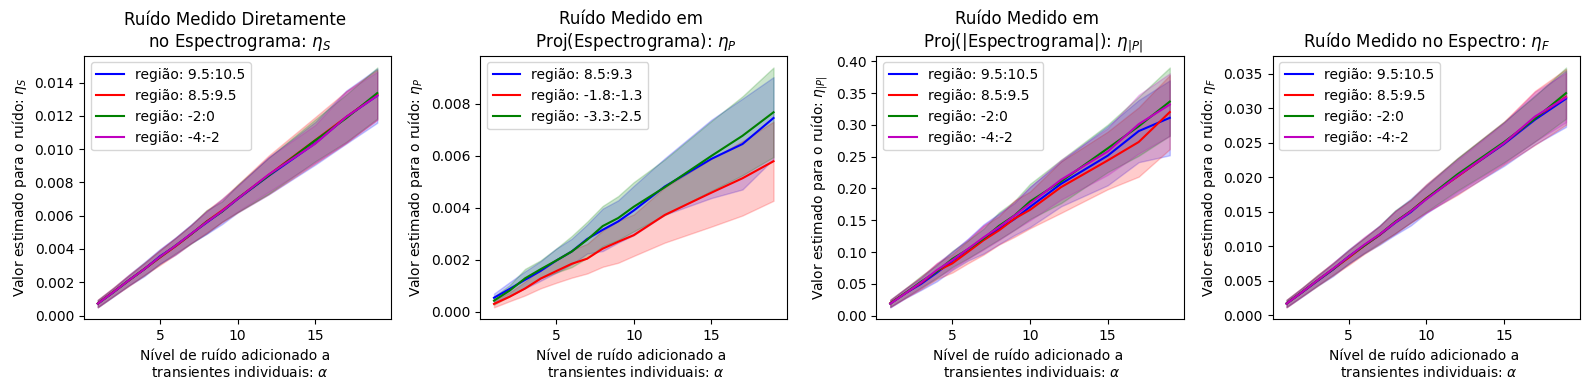

In [37]:
colors = ['b','r','g','m']
fig,ax = plt.subplots(1,4,figsize=(16,4))

for j in range(len(list_ppm_regions_spectrum)):
    aux = np.array(std_estimated_in_spgram[str(list_ppm_regions_spectrum[j][0])+':'+str(list_ppm_regions_spectrum[j][1])]['mean'])
    aux_std = np.array(std_estimated_in_spgram[str(list_ppm_regions_spectrum[j][0])+':'+str(list_ppm_regions_spectrum[j][1])]['std'])
    ax[0].plot(std_basis,aux,label='região: '+str(list_ppm_regions_spectrum[j][0])+':'+str(list_ppm_regions_spectrum[j][1]),color=colors[j])
    ax[0].fill_between(std_basis, aux - aux_std, 
                        aux + aux_std, alpha=0.2, color = colors[j])
ax[0].legend(loc='upper left')
ax[0].set_xlabel('Nível de ruído adicionado a \n transientes individuais: 'r'$\alpha$')
ax[0].set_ylabel('Valor estimado para o ruído: '+r'$\eta_S$')
ax[0].set_title('Ruído Medido Diretamente \n no Espectrograma: '+r'$\eta_S$')

for j in range(len(list_ppm_regions_real)):
    aux = np.array(std_estimate_real[str(list_ppm_regions_real[j][0])+':'+str(list_ppm_regions_real[j][1])]['mean'])
    aux_std = np.array(std_estimate_real[str(list_ppm_regions_real[j][0])+':'+str(list_ppm_regions_real[j][1])]['std'])
    ax[1].plot(std_basis,aux,label='região: '+str(list_ppm_regions_real[j][0])+':'+str(list_ppm_regions_real[j][1]),color=colors[j])
    ax[1].fill_between(std_basis, aux - aux_std, 
                        aux + aux_std, alpha=0.2, color = colors[j])
ax[1].legend(loc='upper left')
ax[1].set_xlabel('Nível de ruído adicionado a \n transientes individuais: 'r'$\alpha$')
ax[1].set_ylabel('Valor estimado para o ruído: '+r'$\eta_P$')
ax[1].set_title('Ruído Medido em \n Proj(Espectrograma): '+r'$\eta_P$')

for j in range(len(list_ppm_regions_abs)):
    aux = np.array(std_estimate_abs[str(list_ppm_regions_abs[j][0])+':'+str(list_ppm_regions_abs[j][1])]['mean'])
    aux_std = np.array(std_estimate_abs[str(list_ppm_regions_abs[j][0])+':'+str(list_ppm_regions_abs[j][1])]['std'])
    ax[2].plot(std_basis,aux,label='região: '+str(list_ppm_regions_abs[j][0])+':'+str(list_ppm_regions_abs[j][1]),color=colors[j])
    ax[2].fill_between(std_basis, aux - aux_std, 
                        aux + aux_std, alpha=0.2, color = colors[j])
ax[2].legend(loc='upper left')
ax[2].set_xlabel('Nível de ruído adicionado a \n transientes individuais: 'r'$\alpha$')
ax[2].set_ylabel('Valor estimado para o ruído: '+r'$\eta_{|P|}$')
ax[2].set_title('Ruído Medido em \n Proj(|Espectrograma|): '+r'$\eta_{|P|}$')


for j in range(len(list_ppm_regions_spectrum)):
    aux = np.array(std_estimate_spectrum[str(list_ppm_regions_spectrum[j][0])+':'+str(list_ppm_regions_spectrum[j][1])]['mean'])
    aux_std = np.array(std_estimate_spectrum[str(list_ppm_regions_spectrum[j][0])+':'+str(list_ppm_regions_spectrum[j][1])]['std'])
    ax[3].plot(std_basis,aux,label='região: '+str(list_ppm_regions_spectrum[j][0])+':'+str(list_ppm_regions_spectrum[j][1]),color=colors[j])
    ax[3].fill_between(std_basis, aux - aux_std, 
                        aux + aux_std, alpha=0.2, color = colors[j])
ax[3].legend(loc='upper left')
ax[3].set_xlabel('Nível de ruído adicionado a \n transientes individuais: 'r'$\alpha$')
ax[3].set_ylabel('Valor estimado para o ruído: '+r'$\eta_F$')
ax[3].set_title('Ruído Medido no Espectro: '+r'$\eta_F$')



plt.tight_layout()
if test_not_save == False:
    plt.savefig('./relatorio_imagens/imagens_noise/noise_estimated.png')

## 5.0 O ruído afeta a largura dos picos nas projeções?

Medição da FWHM das projeções para os picos de NAA, GABA e Glx:

In [71]:
list_projections_abs = []
list_projections_real = []
fwhm_ns = {}
idx_fwhm = {}
fwhm_ns_real = {}
idx_fwhm_real = {}
for i in range(len(std_basis)):
    aux_abs = np.sum(np.abs(np.real(spgram_ns['noise_'+str(std_basis[i])][0])), axis = 2)
    aux_abs_mean = np.mean(aux_abs,axis=1,keepdims=True)
    list_projections_abs.append(aux_abs-aux_abs_mean)
    list_projections_real.append(np.sum(np.real(spgram_ns['noise_'+str(std_basis[i])][0]), axis = 2))
    idx_fwhm['noise_'+str(std_basis[i])] = {}
    idx_fwhm_real['noise_'+str(std_basis[i])] = {}

fwhm_ns['NAA'], aux_idx_NAA_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs,list_peak_idx=idx_freq_NAA,list_ppm=list_of_ppm_spects,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='positive')
fwhm_ns['GABA'], aux_idx_GABA_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs,list_peak_idx=idx_freq_GABA,list_ppm=list_of_ppm_spects,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
fwhm_ns['Glx'], aux_idx_Glx_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs,list_peak_idx=idx_freq_Glx,list_ppm=list_of_ppm_spects,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

fwhm_ns_real['NAA'], aux_idx_NAA_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real,list_peak_idx=idx_freq_NAA,list_ppm=list_of_ppm_spects,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='negative')
fwhm_ns_real['GABA'], aux_idx_GABA_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real,list_peak_idx=idx_freq_GABA,list_ppm=list_of_ppm_spects,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
fwhm_ns_real['Glx'], aux_idx_Glx_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real,list_peak_idx=idx_freq_Glx,list_ppm=list_of_ppm_spects,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

for i in range(len(std_basis)):
    idx_fwhm['noise_'+str(std_basis[i])]['NAA'] = aux_idx_NAA_abs[i]
    idx_fwhm['noise_'+str(std_basis[i])]['GABA'] = aux_idx_GABA_abs[i]
    idx_fwhm['noise_'+str(std_basis[i])]['Glx'] = aux_idx_Glx_abs[i]
    idx_fwhm_real['noise_'+str(std_basis[i])]['NAA'] = aux_idx_NAA_real[i]
    idx_fwhm_real['noise_'+str(std_basis[i])]['GABA'] = aux_idx_GABA_real[i]
    idx_fwhm_real['noise_'+str(std_basis[i])]['Glx'] = aux_idx_Glx_real[i]

In [72]:
#for reference FWHM for projections without noise:
fwhm_abs_spgram_gt={}
fwhm_real_spgram_gt={}
fwhm_abs_spgram_gt['NAA'], aux_idx = utils.get_fwhm_in_ppm_for_different_signals(list_signals=[np.sum(np.abs(np.real(spgram_gt)),axis=2)],list_peak_idx=[idx_freq_NAA[0]],list_ppm=[list_of_ppm_spects[0]],peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='positive')
fwhm_abs_spgram_gt['GABA'], aux_idx = utils.get_fwhm_in_ppm_for_different_signals(list_signals=[np.sum(np.abs(np.real(spgram_gt)),axis=2)],list_peak_idx=[idx_freq_GABA[0]],list_ppm=[list_of_ppm_spects[0]],peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
fwhm_abs_spgram_gt['Glx'], aux_idx = utils.get_fwhm_in_ppm_for_different_signals(list_signals=[np.sum(np.abs(np.real(spgram_gt)),axis=2)],list_peak_idx=[idx_freq_Glx[0]],list_ppm=[list_of_ppm_spects[0]],peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')
fwhm_real_spgram_gt['NAA'], aux_idx = utils.get_fwhm_in_ppm_for_different_signals(list_signals=[np.sum(np.real(spgram_gt),axis=2)],list_peak_idx=[idx_freq_NAA[0]],list_ppm=[list_of_ppm_spects[0]],peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='negative')
fwhm_real_spgram_gt['GABA'], aux_idx = utils.get_fwhm_in_ppm_for_different_signals(list_signals=[np.sum(np.real(spgram_gt),axis=2)],list_peak_idx=[idx_freq_GABA[0]],list_ppm=[list_of_ppm_spects[0]],peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
fwhm_real_spgram_gt['Glx'], aux_idx = utils.get_fwhm_in_ppm_for_different_signals(list_signals=[np.sum(np.real(spgram_gt),axis=2)],list_peak_idx=[idx_freq_Glx[0]],list_ppm=[list_of_ppm_spects[0]],peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

Medição FWHM dos espectros:

In [73]:
list_spectrum = []
list_ppm_array_spectrum = []
fwhm_spectrum = {}
idx_fwhm_spectrum = {}
for i in range(len(std_basis)):
    list_spectrum.append(np.real(spectrum_ns["noise_"+str(std_basis[i])]))
    list_ppm_array_spectrum.append(ppm[0,:])
    idx_fwhm_spectrum['noise_'+str(std_basis[i])] = {}

idx_freq_NAA_spectrum = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_ppm_array_spectrum,ppm_point=2.02)
idx_freq_GABA_spectrum = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_ppm_array_spectrum,ppm_point=3.00)
idx_freq_Glx_spectrum = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_ppm_array_spectrum,ppm_point=3.75)

fwhm_spectrum['NAA'], aux_idx_NAA = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_spectrum,list_peak_idx=idx_freq_NAA_spectrum,list_ppm=list_ppm_array_spectrum,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='negative')
fwhm_spectrum['GABA'], aux_idx_GABA = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_spectrum,list_peak_idx=idx_freq_GABA_spectrum,list_ppm=list_ppm_array_spectrum,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
fwhm_spectrum['Glx'], aux_idx_Glx = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_spectrum,list_peak_idx=idx_freq_Glx_spectrum,list_ppm=list_ppm_array_spectrum,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

for i in range(len(std_basis)):
    idx_fwhm_spectrum['noise_'+str(std_basis[i])]['NAA'] = aux_idx_NAA[i]
    idx_fwhm_spectrum['noise_'+str(std_basis[i])]['GABA'] = aux_idx_GABA[i]
    idx_fwhm_spectrum['noise_'+str(std_basis[i])]['Glx'] = aux_idx_Glx[i]

In [74]:
#for reference FWHM for spectrum without noise:
fwhm_spectrum_gt={}
fwhm_spectrum_gt['NAA'], aux_idx = utils.get_fwhm_in_ppm_for_different_signals(list_signals=[spectra_gt_diff],list_peak_idx=[idx_freq_NAA_spectrum[0]],list_ppm=[list_ppm_array_spectrum[0]],peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='negative')
fwhm_spectrum_gt['GABA'], aux_idx = utils.get_fwhm_in_ppm_for_different_signals(list_signals=[spectra_gt_diff],list_peak_idx=[idx_freq_GABA_spectrum[0]],list_ppm=[list_ppm_array_spectrum[0]],peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
fwhm_spectrum_gt['Glx'], aux_idx = utils.get_fwhm_in_ppm_for_different_signals(list_signals=[spectra_gt_diff],list_peak_idx=[idx_freq_Glx_spectrum[0]],list_ppm=[list_ppm_array_spectrum[0]],peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

Visualmente, observa-se:
- Para proj(|Espectrograma|): picos parecem afinar ligeiramente com o aumento do ruído, em especial os picos de GABA e Glx.
- Para proj(Espectrograma): não há diferença na largura dos picos. 
- Para o espectro de GABA:  não há diferença na largura dos picos. 

Das métricas:
- Para proj(|Espectrograma|): nota-se uma elevada incerteza na medição da FWHM, em especial para os picos de GABA e Glx. O aumento de FWHM para o pico de Glx com o ruído provavelmente está ligado a uma dificuldade do algoritmo de identificar o pico na presença de ruído elevado, visto que, visualmente, tal impressão não se verifica. Através da FWHM nota-se um afinamento dos picos de GABA e NAA com o ruído. Todos os picos são mais largos nas projeções com ruído do que a referência sem ruído.
- Para proj(Espectrograma): largura do pico de NAA se mantém constante, enquanto para GABA e Glx a medição apresenta uma incerteza elevada e varia com o ruído, se afastando do valor de referência sem ruído.
- Para o espectro: largura do pico de NAA se mantém constante, enquanto para GABA e Glx a medição apresenta uma incerteza elevada e varia com o ruído, afinando com o ruído.

Nota-se que a métrica FWHM não é muito robusta ao ruído, pois visualmente essas mudanças de largura dos picos não ocorrem ou ocorrem de forma ligeira. Por isso, as análises de resolução via FWHM devem ser acompanhadas de observações visuais, para prevenir conclusões que podem ser derivadas de limitações do cálculo da métrica.


Text(0.5, 1.0, 'Pico de Glx em Proj(|Espectrograma|)')

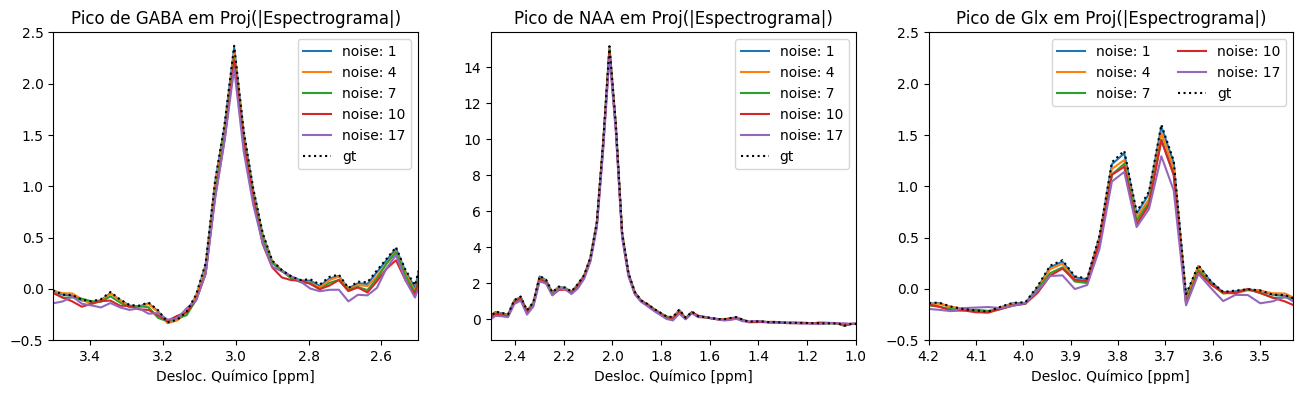

In [67]:
#change the boolean to check the fits in each projection or in the spectrum
plot_projection = True
plot_abs = True
plot_gt = True
transient_idx = 0

colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']
plot_idx = np.arange(0,len(std_basis),3)

if plot_projection == True and plot_abs == False:
    title = 'em Proj(Espectrograma)'
elif plot_projection == True and plot_abs == True:
    title = 'em Proj(|Espectrograma|)'
else:
    title = 'no espectro'

fig,ax = plt.subplots(1,3,figsize=(16,4))
for k in range(len(plot_idx)):
    if plot_projection == True and plot_abs == True:
        #medium level correction
        aux_abs = np.sum(np.abs(np.real(spgram_ns['noise_'+str(std_basis[plot_idx[k]])][0])), axis = 2)
        aux_abs_mean = np.mean(aux_abs)
        aux = np.mean(aux_abs-aux_abs_mean,axis=0)
        aux_xaxis = np.flip(spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2])
    elif plot_projection == True and plot_abs == False:
        aux = np.mean(np.sum(np.real(spgram_ns["noise_"+str(std_basis[plot_idx[k]])][0]),axis=2),axis=0)
        aux_xaxis = np.flip(spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2])
    else:
        aux = np.mean(np.real(spectrum_ns['noise_'+str(std_basis[plot_idx[k]])]),axis=0)
        aux_xaxis = np.flip(ppm[0,:])
        
    ax[0].plot(aux_xaxis,aux, label = "noise: "+str(std_basis[plot_idx[k]]))
    ax[1].plot(aux_xaxis,aux, label = "noise: "+str(std_basis[plot_idx[k]]))
    ax[2].plot(aux_xaxis,aux, label = "noise: "+str(std_basis[plot_idx[k]]))

if plot_gt == True:
    if plot_projection == True and plot_abs == True:
        aux = np.mean(np.sum(np.abs(np.real(spgram_gt)),axis=2),axis=0)-0.4
        aux_xaxis = np.flip(spgram_ns['noise_'+str(std_basis[0])][2])
    elif plot_projection == True and plot_abs == False:
        aux = np.mean(np.sum(np.real(spgram_gt),axis=2),axis=0)
        aux_xaxis = np.flip(spgram_ns['noise_'+str(std_basis[0])][2])
    else:
        aux = np.mean(np.real(spectrum_gt),axis=0)
        aux_xaxis = np.flip(ppm[0,:])
    ax[0].plot(aux_xaxis,aux, label = "gt",color='black',linestyle='dotted')
    ax[1].plot(aux_xaxis,aux, label = "gt",color='black',linestyle='dotted')
    ax[2].plot(aux_xaxis,aux, label = "gt",color='black',linestyle='dotted')

ax[0].set_xlim(3.5,2.5) 
ax[1].set_xlim(2.5,1)  
ax[2].set_xlim(4.2,3.43)

if plot_projection == True and plot_abs == True:
    ax[0].set_ylim(-0.5,2.5)
    ax[2].set_ylim(-0.5,2.5)
elif plot_projection == True and plot_abs == False:
    ax[1].set_ylim(-0.6,1)
    ax[2].set_ylim(-0.05,0.2)
else:
    ax[0].set_ylim(-0.05,0.25)
    ax[2].set_ylim(-0.05,0.25)
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')
ax[2].legend(loc='upper right',ncols=2)
ax[0].set_xlabel('Desloc. Químico [ppm]')
ax[1].set_xlabel('Desloc. Químico [ppm]')
ax[2].set_xlabel('Desloc. Químico [ppm]')
ax[0].set_title('Pico de GABA '+title)
ax[1].set_title('Pico de NAA '+title)
ax[2].set_title('Pico de Glx '+title)

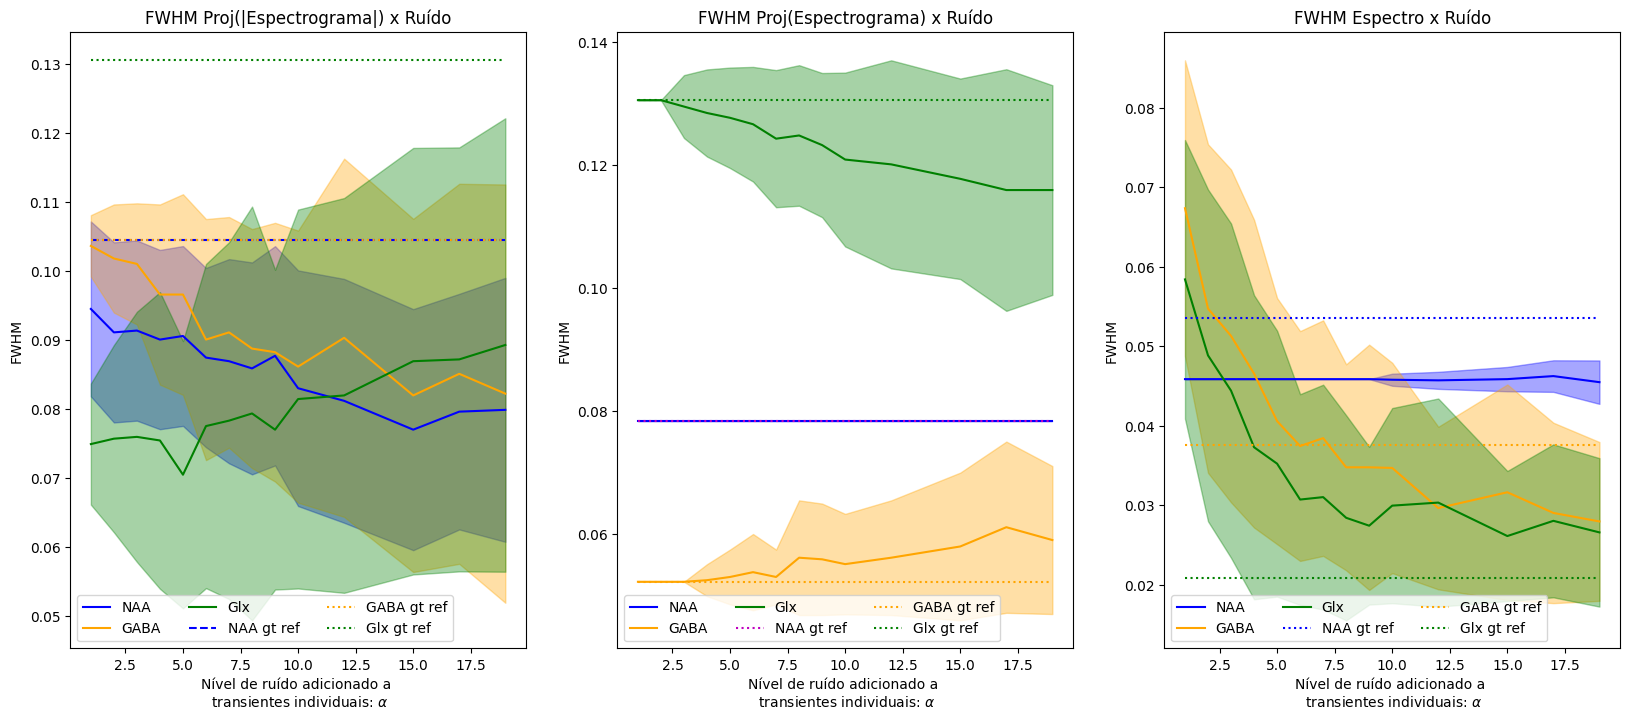

In [82]:
fig,ax = plt.subplots(1,3,figsize=(20,8))
seq_plot = [fwhm_ns,fwhm_ns_real,fwhm_spectrum]
name_plot = ['Proj(|Espectrograma|)','Proj(Espectrograma)','Espectro']
for j in range(3):
    ax.flat[j].plot(std_basis,seq_plot[j]['NAA']['mean'],label='NAA',color='b')
    ax.flat[j].fill_between(std_basis, np.array(seq_plot[j]['NAA']['mean']) - np.array(seq_plot[j]['NAA']['std']), 
                            np.array(seq_plot[j]['NAA']['mean']) + np.array(seq_plot[j]['NAA']['std']), alpha=0.35, color = 'b')
    ax.flat[j].plot(std_basis,seq_plot[j]['GABA']['mean'],label='GABA',color='orange')
    ax.flat[j].fill_between(std_basis, np.array(seq_plot[j]['GABA']['mean']) - np.array(seq_plot[j]['GABA']['std']), 
                            np.array(seq_plot[j]['GABA']['mean']) + np.array(seq_plot[j]['GABA']['std']), alpha=0.35, color = 'orange')
    ax.flat[j].plot(std_basis,seq_plot[j]['Glx']['mean'],label='Glx',color='g')
    ax.flat[j].fill_between(std_basis, np.array(seq_plot[j]['Glx']['mean']) - np.array(seq_plot[j]['Glx']['std']), 
                            np.array(seq_plot[j]['Glx']['mean']) + np.array(seq_plot[j]['Glx']['std']), alpha=0.35, color = 'g')
    ax.flat[j].set_title('FWHM '+name_plot[j]+' x Ruído')
    ax.flat[j].set_xlabel('Nível de ruído adicionado a \n transientes individuais: 'r'$\alpha$')
    ax.flat[j].set_ylabel('FWHM')
ax.flat[0].hlines(fwhm_abs_spgram_gt['NAA']['mean'],1,19,color='b',linestyle='dashed',label = 'NAA gt ref')
ax.flat[0].hlines(fwhm_abs_spgram_gt['GABA']['mean'],1,19,color='orange',linestyle='dotted',label = 'GABA gt ref')
ax.flat[0].hlines(fwhm_abs_spgram_gt['Glx']['mean'],1,19,color='g',linestyle='dotted',label = 'Glx gt ref')
ax.flat[1].hlines(fwhm_real_spgram_gt['NAA']['mean'],1,19,color='m',linestyle='dotted',label = 'NAA gt ref')
ax.flat[1].hlines(fwhm_real_spgram_gt['GABA']['mean'],1,19,color='orange',linestyle='dotted',label = 'GABA gt ref')
ax.flat[1].hlines(fwhm_real_spgram_gt['Glx']['mean'],1,19,color='g',linestyle='dotted',label = 'Glx gt ref')
ax.flat[2].hlines(fwhm_spectrum_gt['NAA']['mean'],1,19,color='b',linestyle='dotted',label = 'NAA gt ref')
ax.flat[2].hlines(fwhm_spectrum_gt['GABA']['mean'],1,19,color='orange',linestyle='dotted',label = 'GABA gt ref')
ax.flat[2].hlines(fwhm_spectrum_gt['Glx']['mean'],1,19,color='g',linestyle='dotted',label = 'Glx gt ref')

for j in range(3):
    ax.flat[j].legend(loc='lower left',ncols=3)

## 6.0 O ruído afeta a medição da ZCR?

Visualmente, o padrão de listras não parece mudar com o ruído, porém, vamos obter o ZCR apenas como uma forma de testar a robustez da métrica com relação ao ruído.

A métrica parece robusta ao ruído.

In [83]:
zcr_ = paramstud.get_zcr_for_relevant_peaks_for_different_spgrams(spgram_dict=spgram_ns,idx_list_GABA=idx_freq_GABA,idx_list_NAA=idx_freq_NAA,idx_list_Glx=idx_freq_Glx,idx_time_list_0d4=idx_time_0d4)

Text(0.5, 0, 'Nível de ruído adicionado a \n transientes individuais: $\\alpha$')

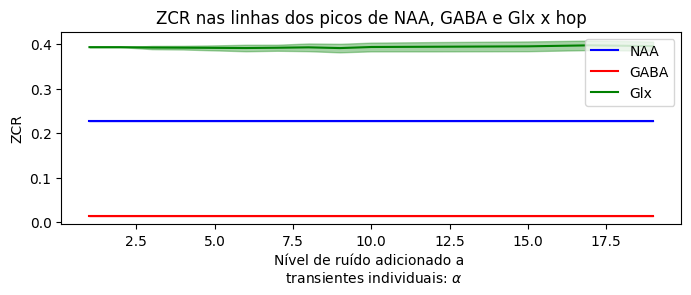

In [96]:
fig,ax = plt.subplots(1,1,figsize=(8,2.5))
ax.plot(std_basis,zcr_['NAA']['mean'],color='b',label='NAA')
ax.fill_between(std_basis, np.array(zcr_['NAA']['mean']) - np.array(zcr_['NAA']['std']), 
                        np.array(zcr_['NAA']['mean']) + np.array(zcr_['NAA']['std']), alpha=0.35, color = 'b')
ax.plot(std_basis,zcr_['GABA']['mean'],color='r',label='GABA')
ax.fill_between(std_basis, np.array(zcr_['GABA']['mean']) - np.array(zcr_['GABA']['std']), 
                        np.array(zcr_['GABA']['mean']) + np.array(zcr_['GABA']['std']), alpha=0.35, color = 'r')
ax.plot(std_basis,zcr_['Glx']['mean'],color='g',label='Glx')
ax.fill_between(std_basis, np.array(zcr_['Glx']['mean']) - np.array(zcr_['Glx']['std']), 
                        np.array(zcr_['Glx']['mean']) + np.array(zcr_['Glx']['std']), alpha=0.35, color = 'g')
ax.legend(loc='upper right')
plt.title('ZCR nas linhas dos picos de NAA, GABA e Glx x hop')
plt.ylabel('ZCR')
plt.xlabel('Nível de ruído adicionado a \n transientes individuais: 'r'$\alpha$')

## 7.0 Segmentação de regiões e estatísticas:

É possível progressivamente segmentar o espectrograma SEM ruído, segmentando regiões com intensidade de pixels cada vez maiores. Essa segmentação pode ser usada como base para entender como tais regiões variam com o aumento do ruído.

Segmentação proposta:

In [88]:
seg_res = (np.abs(np.real(spgram_gt)) < 0.001).astype('int')
seg_res2 = (np.abs(np.real(spgram_gt)) > 0.001).astype('int')*(np.abs(np.real(spgram_gt)) < 0.02).astype('int')
seg_res3 = (np.abs(np.real(spgram_gt)) > 0.02).astype('int')*(np.abs(np.real(spgram_gt)) < 0.08).astype('int')
seg_res4 = (np.abs(np.real(spgram_gt)) > 0.08).astype('int')*(np.abs(np.real(spgram_gt)) < 0.2).astype('int')
seg_res5 = (np.abs(np.real(spgram_gt)) > 0.2).astype('int')*(np.abs(np.real(spgram_gt)) < 0.6).astype('int')
seg_res6 = (np.abs(np.real(spgram_gt)) > 0.6).astype('int')*(np.abs(np.real(spgram_gt[0,:,:])) < 1).astype('int')
masks = [seg_res,seg_res2,seg_res3,seg_res4,seg_res5,seg_res6]

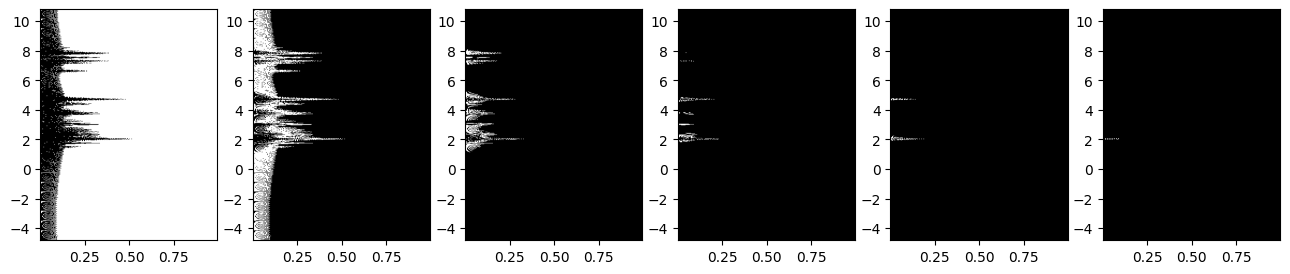

In [89]:
fig,ax = plt.subplots(1,6,figsize=(16,3))
for i in range(6):
    ax[i].imshow(masks[i][0,:,:],cmap='gray',origin='lower',aspect='auto',
            extent = (spgram_ns['noise_'+str(std_basis[0])][-1][0],spgram_ns['noise_'+str(std_basis[0])][-1][-1],
                    np.flip(spgram_ns['noise_'+str(std_basis[0])][2])[0],np.flip(spgram_ns['noise_'+str(std_basis[0])][2])[-1]))

Visualização da segmentação de regiões dos espectrogramas com ruído utilizando a segmentação do espectrograma GT como máscara:

Nota-se que a partir da quarta máscara já não se vê diferença entre as regiões segmentadas de espectrogramas gerados com níveis de ruído diferentes.

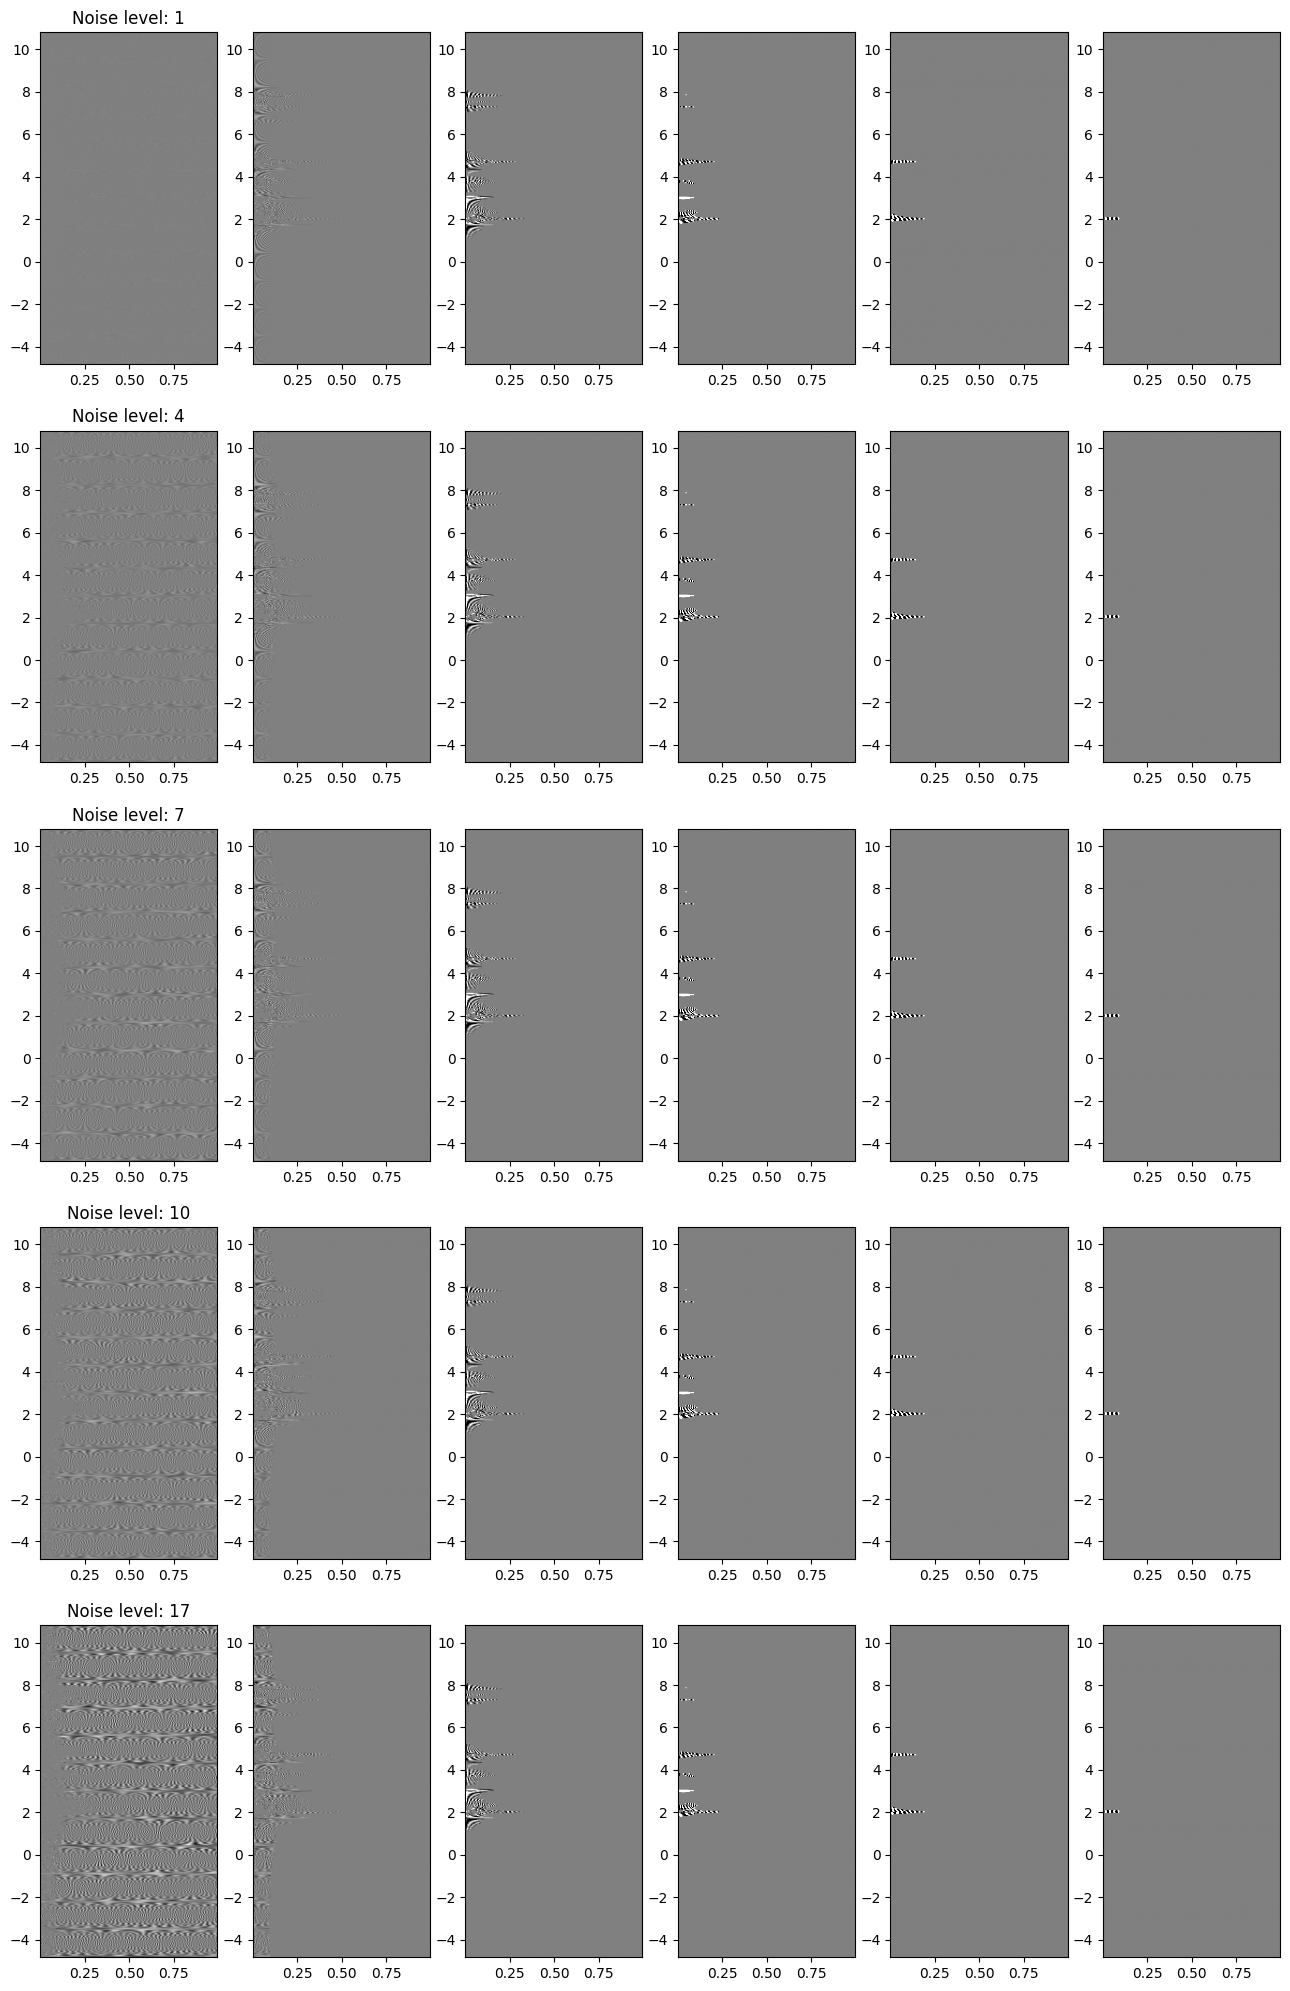

In [91]:
fig,ax = plt.subplots(5,6,figsize=(16,25))
plot_id = np.arange(0,len(std_basis),3)

for idx in range(len(plot_id)):
    for j in range(6):
        ax.flat[6*idx+j].imshow(np.real(spgram_ns['noise_'+str(std_basis[plot_id[idx]])][0][0,:,:])*masks[j][0,:,:],cmap='gray',origin='lower',aspect='auto',vmin=-0.04,vmax=0.04,
                    extent = (spgram_ns['noise_'+str(std_basis[plot_id[idx]])][-1][0],spgram_ns['noise_'+str(std_basis[plot_id[idx]])][-1][-1],
                    np.flip(spgram_ns['noise_'+str(std_basis[plot_id[idx]])][2])[0],np.flip(spgram_ns['noise_'+str(std_basis[plot_id[idx]])][2])[-1]))
    ax.flat[6*idx].set_title('Noise level: '+str(std_basis[plot_id[idx]]))

Pode-se extrair estatísticas de cada região mascarada em função do nível de ruído:

Nos gráficos abaixo, cada coluna traz uma estatística observada e cada cor representa uma região segmentada. Observa-se a evolução da região segundo cada estatística em função do ruído adicionado.

As regiões mais afetadas pelo ruído são as das trÊs primeiras máscaras, onde o ruído afeta significativamente o desvio-padrão medido e a kurtosis. A média tende a se manter constante para as três regiões, mas a mediana é mais sensível ao ruído. A skewness se afasta de zero na região da máscara 2.

A máscara 3 também é afetada pelo ruído, apesar de visualmente não se notar mudanças. O efeito do ruído impacta prinicpalmente a mediana e kurtosis.

As duas demais máscaras tendem a ter estatísticas constante com o ruído.

Finalmente, o comportamento do ruído afeta principalmente o desvio-padrão e a kurtosis do espectrograma de modo global.

In [92]:
stats_per_region = noisestud.stats_per_masked_regions_for_different_spgrams(masks=masks,spgram_dict=spgram_ns, part='real')

In [93]:
stats_global = utils.stats_global_for_different_spgrams(spgram_dict=spgram_ns, part='part')

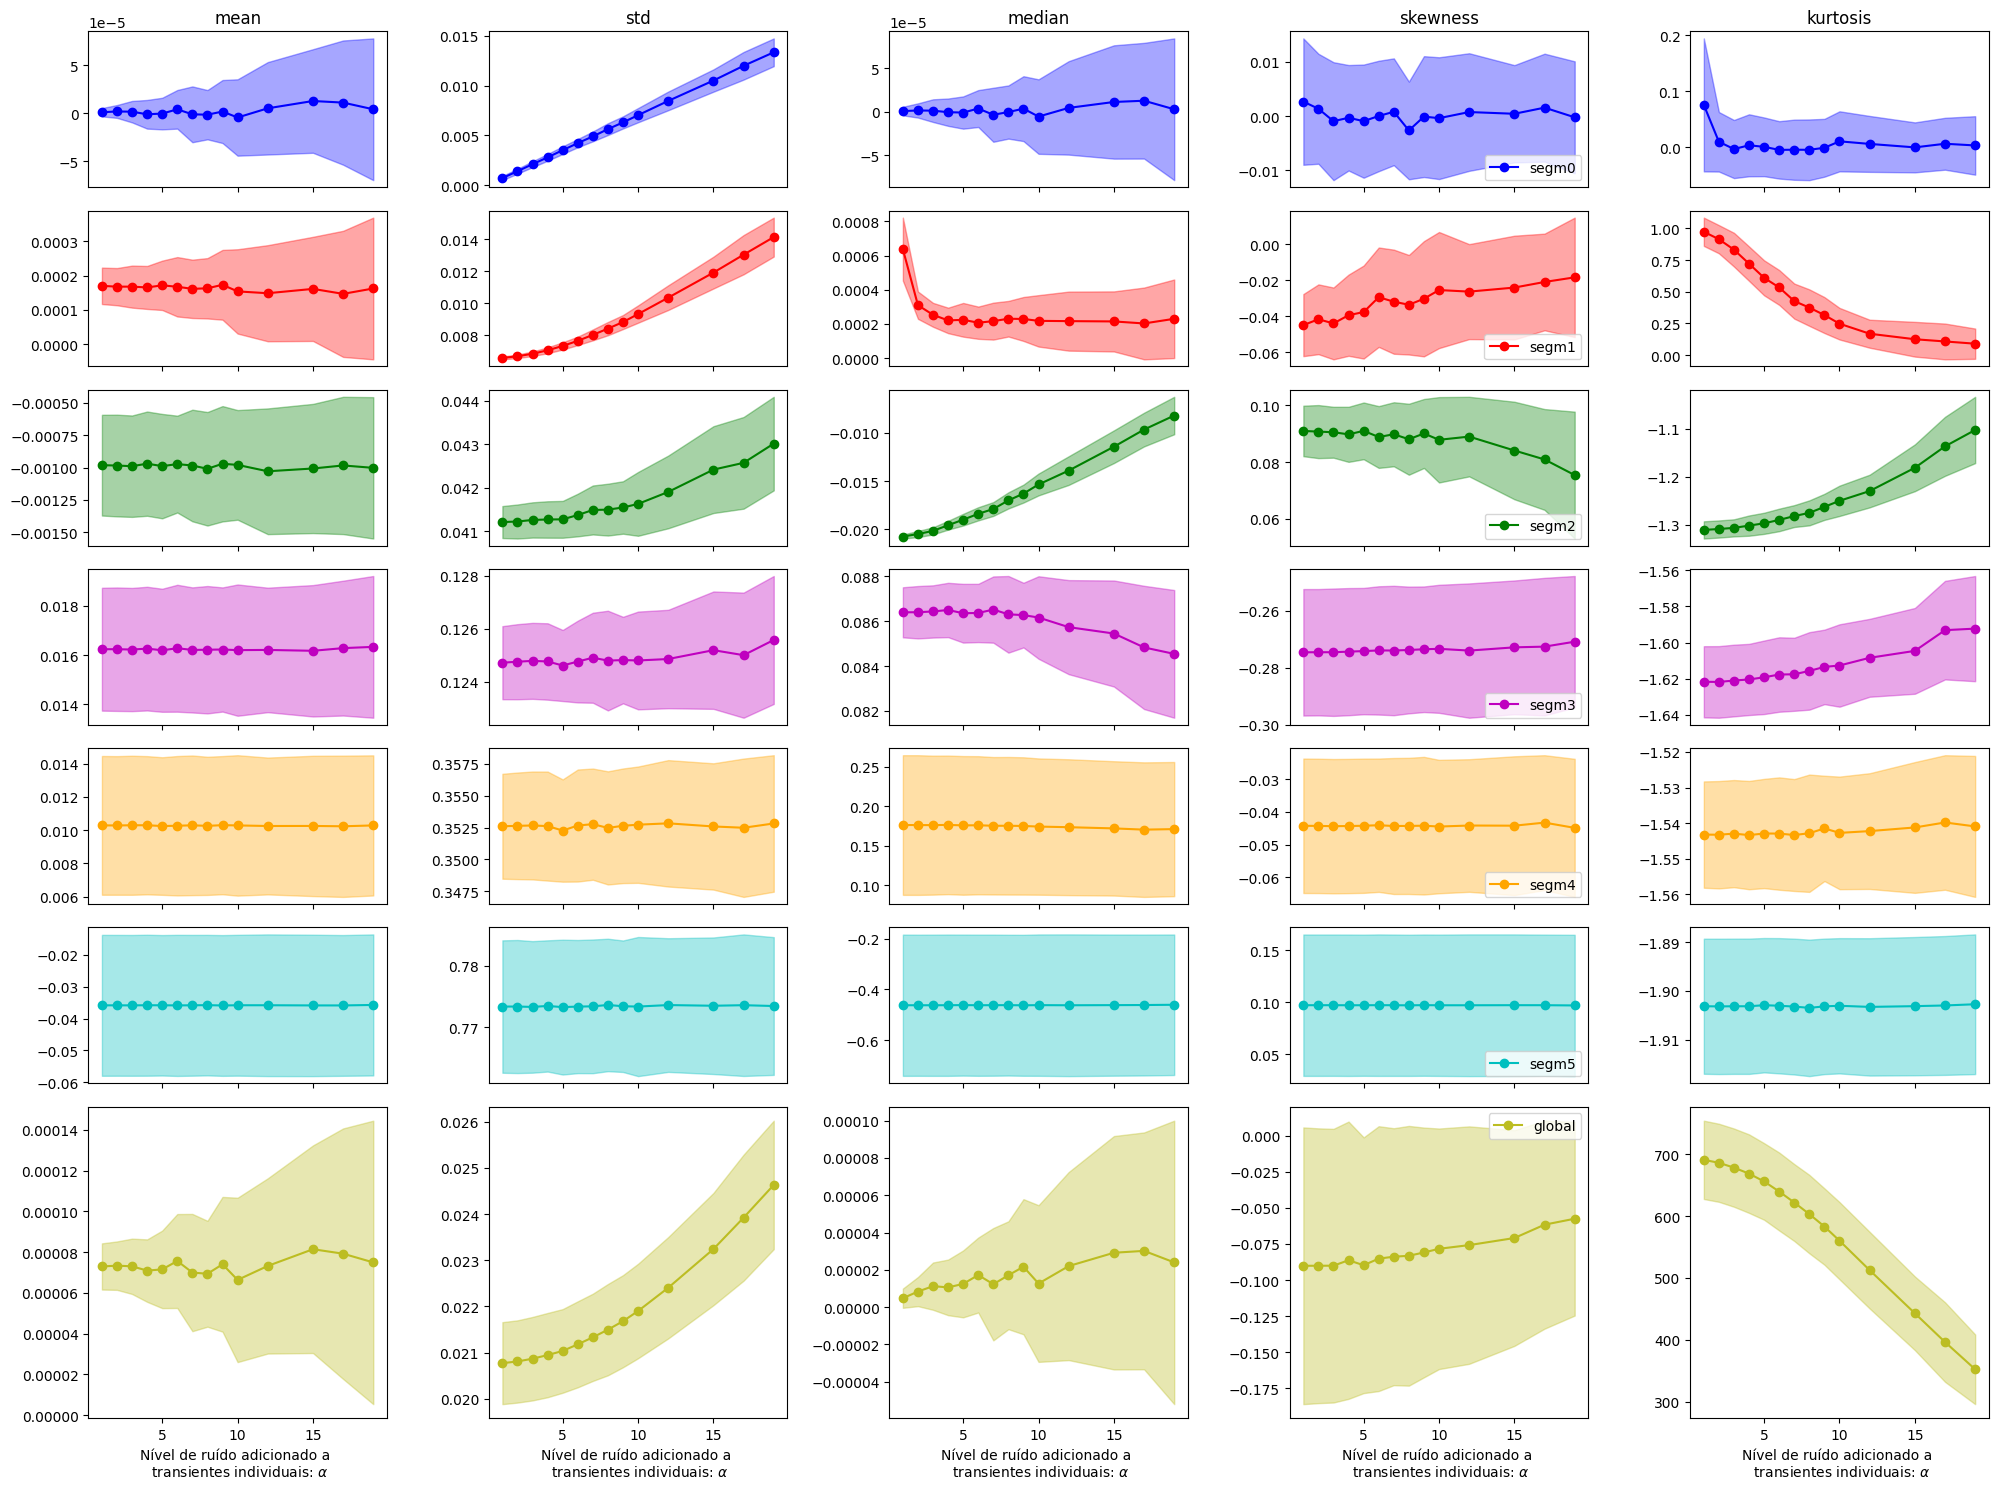

In [98]:
fig,ax = plt.subplots(7,5,figsize=(20,15), sharex='col', height_ratios=[1, 1, 1, 1, 1, 1, 2])

title_name = ['média','desvio padrão','mediana','skewness','kurtosis']
stat_name = ['mean','std','median','skewness','kurtosis']
colors = ['b','r','g','m','orange','c']
for j in range(len(stat_name)):
    for i in range(len(list(stats_per_region[stat_name[j]].keys()))):
        aux = np.array(stats_per_region[stat_name[j]][list(stats_per_region[stat_name[j]].keys())[i]]['mean'])
        aux_std = np.array(stats_per_region[stat_name[j]][list(stats_per_region[stat_name[j]].keys())[i]]['std'])
        ax[i,j].plot(std_basis,aux,marker='o',color=colors[i],label='segm'+list(stats_per_region[stat_name[j]].keys())[i])
        ax[i,j].fill_between(std_basis, aux - aux_std, 
                           aux + aux_std, alpha=0.35, color = colors[i])
        if i == 0:
            ax[i,j].set_title(stat_name[j])
        if j == 3:
            ax[i,j].legend(loc='lower right')
colors = ['#bcbd22']
for i in range(len(stat_name)):
    aux = np.array(stats_global[stat_name[i]]['mean'])
    aux_std = np.array(stats_global[stat_name[i]]['std'])
    ax[6,i].plot(std_basis,aux,marker='o',color=colors[0],label="global")
    ax[6,i].fill_between(std_basis, aux - aux_std, 
                       aux + aux_std, alpha=0.35, color = colors[0])
    if i == 3:
        ax[6,i].legend(loc='upper right')
for i in range(len(stat_name)):
    ax[-1,i].set_xlabel('Nível de ruído adicionado a \n transientes individuais: 'r'$\alpha$')
plt.tight_layout()

## 8.0 Salva dataset com métricas obtidas:

In [115]:
if test_not_save == False:
    zcr_list = {}
    zcr_list['NAA'] = {}
    zcr_list['NAA']['mean'] = list(zcr_['NAA']['mean'])
    zcr_list['NAA']['std'] = list(zcr_['NAA']['std'])
    zcr_list['GABA'] = {}
    zcr_list['GABA']['mean'] = list(zcr_['GABA']['mean'])
    zcr_list['GABA']['std'] = list(zcr_['GABA']['std'])
    zcr_list['Glx'] = {}
    zcr_list['Glx']['mean'] = list(zcr_['Glx']['mean'])
    zcr_list['Glx']['std'] = list(zcr_['Glx']['std'])
    std_estimate_abs_wto_avg_coef = {}
    for key in list(std_estimate_abs.keys()):
        std_estimate_abs_wto_avg_coef[key] = {'mean':std_estimate_abs[key]['mean'],'std':std_estimate_abs[key]['std']}
    std_estimate_real_wto_avg_coef = {}
    for key in list(std_estimate_real.keys()):
        std_estimate_real_wto_avg_coef[key] = {'mean':std_estimate_real[key]['mean'],'std':std_estimate_real[key]['std']}
    std_estimate_spectrum_wto_avg_coef = {}
    for key in list(std_estimate_spectrum.keys()):
        std_estimate_spectrum_wto_avg_coef[key] = {'mean':std_estimate_spectrum[key]['mean'],'std':std_estimate_spectrum[key]['std']}
    noise_added_indv_transients = {'std_basis':std_basis,'var_basis':var_basis}
    with open("quantitative_metrics_noise_variation_mfft_600_hop_12_win_hann_norm_abs.txt", "w") as f:
        f.write("noise_added_indv_transients=")
        f.write(json.dumps(noise_added_indv_transients))
        f.write('\n')
        f.write("std_estimate_abs=")
        f.write(json.dumps(std_estimate_abs_wto_avg_coef))
        f.write('\n')
        f.write("std_estimate_real=")
        f.write(json.dumps(std_estimate_real_wto_avg_coef))
        f.write('\n')
        f.write("std_estimate_spectrum=")
        f.write(json.dumps(std_estimate_spectrum_wto_avg_coef))
        f.write('\n')
        f.write("std_estimated_in_spgram=")
        f.write(json.dumps(std_estimated_in_spgram))
        f.write('\n')
        f.write("fwhm_ns=")
        f.write(json.dumps(fwhm_ns))
        f.write('\n')
        f.write("fwhm_ns_real=")
        f.write(json.dumps(fwhm_ns_real))
        f.write('\n')
        f.write("fwhm_abs_spgram_gt=")
        f.write(json.dumps(fwhm_abs_spgram_gt))
        f.write('\n')
        f.write("fwhm_real_spgram_gt=")
        f.write(json.dumps(fwhm_real_spgram_gt))
        f.write('\n')
        f.write("fwhm_spectrum=")
        f.write(json.dumps(fwhm_spectrum))
        f.write('\n')
        f.write("fwhm_spectrum_gt=")
        f.write(json.dumps(fwhm_spectrum_gt))
        f.write('\n')
        f.write("zcr_=")
        f.write(json.dumps(zcr_list))
        f.write('\n')
        f.write("stats_per_region=")
        f.write(json.dumps(stats_per_region))
        f.write('\n')
        f.write("stats_global=")
        f.write(json.dumps(stats_global))